In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertConfig, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
class PrecomputedContrastiveSmilesDataset(Dataset):
    """
    A Dataset class that reads pre-augmented SMILES pairs from a Parquet file.
    This is significantly faster as it offloads the expensive SMILES randomization
    to a one-time preprocessing step.
    """
    def __init__(self, tokenizer, file_path: str, max_length: int = 512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Load the entire dataset from the Parquet file into memory.
        # This is fast and efficient for subsequent access.
        print(f"Loading pre-computed data from {file_path}...")
        self.data = pd.read_parquet(file_path)
        print("Data loaded successfully.")

    def __len__(self):
        """Returns the total number of pairs in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a pre-augmented pair, tokenizes it, and returns it
        in the format expected by the DataCollator.
        """
        # Retrieve the pre-augmented pair from the DataFrame
        row = self.data.iloc[idx]
        smiles_1 = row['smiles_1']
        smiles_2 = row['smiles_2']
        
        # Tokenize the pair. This operation is fast and remains in the data loader.
        tokens_1 = self.tokenizer(smiles_1, max_length=self.max_length, truncation=True, padding='max_length')
        tokens_2 = self.tokenizer(smiles_2, max_length=self.max_length, truncation=True, padding='max_length')
        
        return {
            'input_ids_1': torch.tensor(tokens_1['input_ids']),
            'attention_mask_1': torch.tensor(tokens_1['attention_mask']),
            'input_ids_2': torch.tensor(tokens_2['input_ids']),
            'attention_mask_2': torch.tensor(tokens_2['attention_mask']),
        }

def global_ap(x):
    return torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)

class SimSonEncoder(nn.Module):
    def __init__(self, config: BertConfig, max_len: int, dropout: float = 0.1):
        super(SimSonEncoder, self).__init__()
        self.config = config
        self.max_len = max_len
        self.bert = BertModel(config, add_pooling_layer=False)
        self.linear = nn.Linear(config.hidden_size, max_len)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids, attention_mask=None):
        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.dropout(outputs.last_hidden_state)
        pooled = global_ap(hidden_states)
        return self.linear(pooled)


In [3]:
tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MTR')
model_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=4,
    num_attention_heads=12,
    intermediate_size=2048,
    max_position_embeddings=512
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimSonEncoder(config=model_config, max_len=512).to(device)
model = torch.compile(model)
model.load_state_dict(torch.load('/home/jovyan/simson_training_bolgov/simson_checkpoints_polymer_1M/simson_model_single_gpu.bin'))
model.eval()

OptimizedModule(
  (_orig_mod): SimSonEncoder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(591, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-3): 4 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)

In [4]:
test_data = pd.read_parquet('/home/jovyan/simson_training_bolgov/data/polymer_splits/test.parquet')
print(f"Test dataset shape: {test_data.shape}")
print(f"Columns: {test_data.columns.tolist()}")
test_data.head()

Test dataset shape: (5000, 2)
Columns: ['smiles_1', 'smiles_2']


smiles_1  \
0  c1c(ccc(c1)OC(=O)CCCS(CCCc1ccc(C(O*)=O)cc1)(=O...   
1  C(CC(=O)NCCC[Si](O*)(C)C)CCCCC(OCCCCCOC(Cc1cc(...   
2                   C(SCCNC(OCC*)=O)CSCCCOCCNC(=O)O*   
3                     *CCCCOC(=O)CSCCCC[PH](C)(=O)O*   
4                   C(O*)COCCOCCN(C(=O)OCCC*)C(=O)OC   

                                            smiles_2  
0  c1cc(ccc1OC(CCCS(CCCc1ccc(C(=O)O*)cc1)(=O)=O)=...  
1  CN(*)Cc1cccc(c1)CC(OCCCCCOC(CCCCCCC(=O)NCCC[Si...  
2                     O=C(OCC*)NCCSCCSCCCOCCNC(O*)=O  
3                     *CCCCOC(=O)CSCCCC[PH](C)(=O)O*  
4                   C(CC*)OC(=O)N(C(=O)OC)CCOCCOCCO*

In [5]:
def generate_embeddings(model, tokenizer, smiles_list, batch_size=256, max_length=512):
    """Generate embeddings for a list of SMILES strings"""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(smiles_list), batch_size):
            batch_smiles = smiles_list[i:i+batch_size]
            
            # Tokenize batch
            tokens = tokenizer(batch_smiles, 
                             max_length=max_length, 
                             truncation=True, 
                             padding='max_length', 
                             return_tensors='pt')
            
            # Move to device
            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)
            
            # Generate embeddings
            batch_embeddings = model(input_ids, attention_mask)
            embeddings.append(batch_embeddings.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_smiles)} / {len(smiles_list)} SMILES")
    
    return np.vstack(embeddings)

# Generate embeddings for original and augmented SMILES
print("Generating embeddings for original SMILES...")
original_embeddings = generate_embeddings(model, tokenizer, test_data['smiles_1'].tolist())

print("Generating embeddings for augmented SMILES...")
augmented_embeddings = generate_embeddings(model, tokenizer, test_data['smiles_2'].tolist())

print(f"Original embeddings shape: {original_embeddings.shape}")
print(f"Augmented embeddings shape: {augmented_embeddings.shape}")


Generating embeddings for original SMILES...
Processed 2560 / 5000 SMILES
Processed 5000 / 5000 SMILES
Generating embeddings for augmented SMILES...
Processed 2560 / 5000 SMILES
Processed 5000 / 5000 SMILES
Original embeddings shape: (5000, 512)
Augmented embeddings shape: (5000, 512)


Average cosine similarity between original and augmented SMILES: 0.9874
Standard deviation: 0.0197
Min similarity: 0.7691
Max similarity: 1.0000


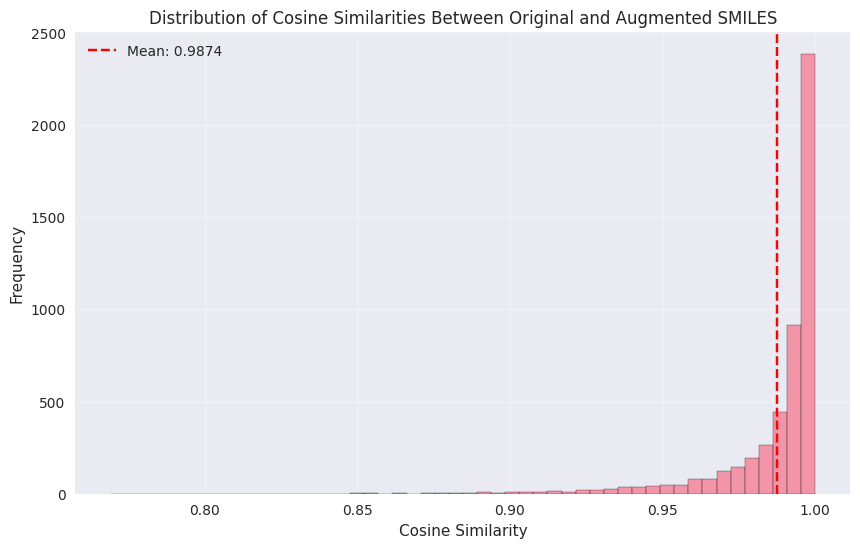

In [6]:
def calculate_pairwise_similarities(embeddings1, embeddings2):
    """Calculate cosine similarities between corresponding pairs"""
    similarities = []
    for i in range(len(embeddings1)):
        sim = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
        similarities.append(sim)
    return np.array(similarities)

# Calculate cosine similarities
pairwise_similarities = calculate_pairwise_similarities(original_embeddings, augmented_embeddings)

print(f"Average cosine similarity between original and augmented SMILES: {np.mean(pairwise_similarities):.4f}")
print(f"Standard deviation: {np.std(pairwise_similarities):.4f}")
print(f"Min similarity: {np.min(pairwise_similarities):.4f}")
print(f"Max similarity: {np.max(pairwise_similarities):.4f}")

# Plot similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(pairwise_similarities, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(pairwise_similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(pairwise_similarities):.4f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities Between Original and Augmented SMILES')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# 1. Embedding Space Statistics
def analyze_embedding_space(original_emb, augmented_emb):
    """Analyze the embedding space properties"""
    print("=== Embedding Space Analysis ===")
    
    # Dimensionality and norms
    print(f"Embedding dimensionality: {original_emb.shape[1]}")
    print(f"Average L2 norm (original): {np.mean(np.linalg.norm(original_emb, axis=1)):.4f}")
    print(f"Average L2 norm (augmented): {np.mean(np.linalg.norm(augmented_emb, axis=1)):.4f}")
    
    # Intra-class similarities
    orig_similarities = cosine_similarity(original_emb)
    aug_similarities = cosine_similarity(augmented_emb)
    
    # Remove diagonal (self-similarity)
    orig_similarities_off_diag = orig_similarities[np.triu_indices_from(orig_similarities, k=1)]
    aug_similarities_off_diag = aug_similarities[np.triu_indices_from(aug_similarities, k=1)]
    
    print(f"Average intra-class similarity (original): {np.mean(orig_similarities_off_diag):.4f}")
    print(f"Average intra-class similarity (augmented): {np.mean(aug_similarities_off_diag):.4f}")
    
    # Inter-class similarities
    inter_similarities = cosine_similarity(original_emb, augmented_emb)
    print(f"Average inter-class similarity: {np.mean(inter_similarities):.4f}")

analyze_embedding_space(original_embeddings, augmented_embeddings)

# 2. Nearest Neighbor Analysis
def nearest_neighbor_analysis(original_emb, augmented_emb, k=5):
    """Analyze nearest neighbors between original and augmented embeddings"""
    print(f"\n=== Nearest Neighbor Analysis (k={k}) ===")
    
    # For each original embedding, find its k nearest neighbors in augmented set
    similarities = cosine_similarity(original_emb, augmented_emb)
    
    # Find cases where augmented version is among top-k neighbors
    correct_matches = 0
    top1_matches = 0
    
    for i in range(len(original_emb)):
        # Get similarity scores for i-th original embedding
        sim_scores = similarities[i]
        top_k_indices = np.argsort(sim_scores)[-k:][::-1]
        
        if i in top_k_indices:
            correct_matches += 1
        if np.argmax(sim_scores) == i:
            top1_matches += 1
    
    print(f"Augmented SMILES in top-{k} neighbors: {correct_matches}/{len(original_emb)} ({100*correct_matches/len(original_emb):.1f}%)")
    print(f"Augmented SMILES as top-1 neighbor: {top1_matches}/{len(original_emb)} ({100*top1_matches/len(original_emb):.1f}%)")

nearest_neighbor_analysis(original_embeddings, augmented_embeddings)

=== Embedding Space Analysis ===
Embedding dimensionality: 512
Average L2 norm (original): 11.9105
Average L2 norm (augmented): 11.9072
Average intra-class similarity (original): 0.0047
Average intra-class similarity (augmented): 0.0048
Average inter-class similarity: 0.0049

=== Nearest Neighbor Analysis (k=5) ===
Augmented SMILES in top-5 neighbors: 5000/5000 (100.0%)
Augmented SMILES as top-1 neighbor: 4872/5000 (97.4%)


Объяснение

* Embedding Space Analysis. Показывает, что различные величины (L2 norm - длина вектора, близости) практически идентичны для оригинальных, и для аугментированных молекул (показывая, что они отображаются практически одними и теми же для модели)
* Nearest Neighbor Analysis (k=5). Показывает, что топ 5 ближайших векторов к любому из векторов - всегда его аугментация (кроме его самого, естественно). В 97.4 % случаях вектор, соответствующий аугментации, является ближайшим.

С разными SMILES - ровно обратная картина, как и должно быть (различные smiles являются очень разными)

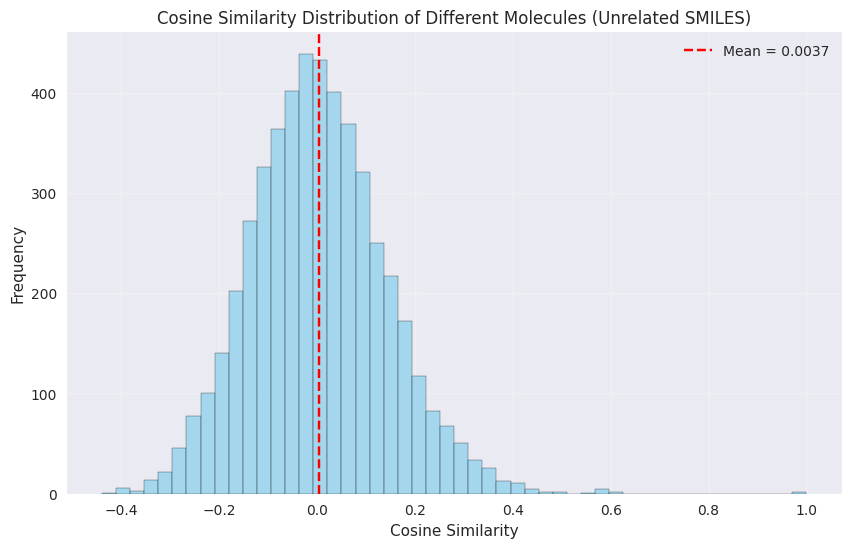

In [8]:


num_molecules = original_embeddings.shape[0]

# Shuffle indices for unrelated molecules
unrelated_indices = np.random.permutation(num_molecules)
unrelated_embeddings = augmented_embeddings[unrelated_indices]

# Compute pairwise cosine similarity between original and unrelated
pairwise_unrelated_similarities = np.array([
    cosine_similarity([original_embeddings[i]], [unrelated_embeddings[i]])[0][0]
    for i in range(num_molecules)
])


plt.figure(figsize=(10,6))
plt.hist(pairwise_unrelated_similarities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
mean_sim = pairwise_unrelated_similarities.mean()
plt.axvline(mean_sim, color='red', linestyle='--', label=f'Mean = {mean_sim:.4f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution of Different Molecules (Unrelated SMILES)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
print(f"Mean cosine similarity: {pairwise_unrelated_similarities.mean():.4f}")
print(f"Std deviation: {pairwise_unrelated_similarities.std():.4f}")
print(f"Range: {pairwise_unrelated_similarities.min():.4f} to {pairwise_unrelated_similarities.max():.4f}")


Mean cosine similarity: 0.0037
Std deviation: 0.1393
Range: -0.4398 to 1.0000


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

k = 5
similarities = cosine_similarity(original_embeddings, unrelated_embeddings)
correct_matches = sum(i in np.argsort(similarities[i])[-k:] for i in range(num_molecules))
top1_matches = sum(np.argmax(similarities[i]) == i for i in range(num_molecules))

print(f"Unrelated in top-{k} neighbors: {correct_matches}/{num_molecules}")
print(f"Unrelated as top-1 neighbor: {top1_matches}/{num_molecules}")


Unrelated in top-5 neighbors: 7/5000
Unrelated as top-1 neighbor: 2/5000
